# Single Config Experiment Runner

Use this notebook to run exactly one experiment definition declared directly in the cell below.
It builds the dataloaders/model based on that config and prints the train/validation loss after each epoch.


In [1]:
import json
from dataclasses import replace
from pathlib import Path

import torch
from torch.utils.data import DataLoader
import copy

import os
os.chdir("/workspace/tubes_2_asr_javanese")
print("CWD =", os.getcwd())

from config import Config
from src.dataset import JavaneseASRDataset, collate_fn
from src.features import LogMelFeatureExtractor
from src.vocab import Vocabulary
from src.decoder import GreedyDecoder
from src.utils import set_seed, read_transcript, count_parameters
from src.data_split import create_speaker_disjoint_split, load_split_info
from src.model import Seq2SeqASR
from scripts.train import train_one_epoch, validate_with_metrics


CWD = /workspace/tubes_2_asr_javanese


In [2]:
EXPERIMENT_7 = {
    "name": "Char-PBLSTM-CTC0.7-Optimal",
    "description": "Character vocab with joint CTC-attention for alignment help.",
    "config": {
        "token_type": "char",
        "encoder_type": "pyramidal",
        "decoder_type": "lstm",
        "learning_rate": 1e-3,
        "num_epochs": 100,
        "use_ctc": True,
        "ctc_weight": 0.7,
        "encoder_hidden_size": 320,
        "decoder_dim": 640,
        "batch_size": 4
    },
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

base_config = Config()
current_config = replace(base_config, **EXPERIMENT_7["config"])
current_config = replace(current_config, device=DEVICE)

print(f"Selected experiment: {EXPERIMENT_7['name']}")
print(f"Device: {current_config.device}")
print(f"Epochs: {current_config.num_epochs}, batch_size: {current_config.batch_size}, lr: {current_config.learning_rate}")

Selected experiment: Char-PBLSTM-CTC0.7-Optimal
Device: cuda
Epochs: 100, batch_size: 4, lr: 0.001


In [3]:
def build_dataloaders(cfg: Config):
    transcripts = read_transcript(cfg.transcript_file)
    vocab = Vocabulary(token_type=cfg.token_type)
    vocab.build_from_transcripts(transcripts, min_freq=1)

    feature_extractor = LogMelFeatureExtractor(
        sample_rate=cfg.sample_rate,
        n_mels=cfg.n_mels
    )

    split_info_path = Path(cfg.split_info_path)
    if split_info_path.exists():
        split_info = load_split_info(str(split_info_path))
        split_dict = split_info["split"]
    else:
        split_dict = create_speaker_disjoint_split(
            transcript_file=cfg.transcript_file,
            seed=cfg.seed,
            save_split_info=True,
            split_info_path=str(split_info_path)
        )

    train_dataset = JavaneseASRDataset(
        audio_dir=cfg.audio_dir,
        transcript_file=cfg.transcript_file,
        vocab=vocab,
        feature_extractor=feature_extractor,
        apply_spec_augment=cfg.apply_spec_augment,
        utt_id_filter=split_dict["train"]
    )

    val_dataset = JavaneseASRDataset(
        audio_dir=cfg.audio_dir,
        transcript_file=cfg.transcript_file,
        vocab=vocab,
        feature_extractor=feature_extractor,
        apply_spec_augment=False,
        utt_id_filter=split_dict["val"]
    )

    use_pin_memory = torch.cuda.is_available()
    train_loader = DataLoader(
        train_dataset,
        batch_size=cfg.batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=4,
        pin_memory=use_pin_memory,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=cfg.batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=4,
        pin_memory=use_pin_memory,
    )
    return vocab, train_loader, val_loader


In [4]:
set_seed(current_config.seed)

vocab, train_loader, val_loader = build_dataloaders(current_config)
print(f"Vocabulary size: {len(vocab)}")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

model = Seq2SeqASR(
    vocab_size=len(vocab),
    input_dim=current_config.input_dim,
    encoder_hidden_size=current_config.encoder_hidden_size,
    encoder_num_layers=current_config.encoder_num_layers,
    decoder_dim=current_config.decoder_dim,
    attention_dim=current_config.attention_dim,
    embedding_dim=current_config.embedding_dim,
    dropout=current_config.dropout,
    use_ctc=current_config.use_ctc,
    ctc_weight=current_config.ctc_weight,
    encoder_type=current_config.encoder_type,
    decoder_type=current_config.decoder_type,
).to(current_config.device)
print(f"Model parameters: {count_parameters(model):,}")

optimizer = torch.optim.Adam(model.parameters(), lr=current_config.learning_rate)
decoder = GreedyDecoder(model, vocab, max_len=current_config.max_decode_len, device=current_config.device)

train_losses, val_losses, val_cers, val_wers = [], [], [], []

patience = 5  # early stopping rounds
bad_epochs = 0
best_val_loss = float("inf")
best_state = None
best_epoch = 0

import time

total_start = time.time() 

for epoch in range(1, current_config.num_epochs + 1):
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        vocab,
        current_config.device,
        epoch,
        current_config.grad_clip_norm,
    )
    val_loss, val_cer, val_wer, _, _ = validate_with_metrics(
        model,
        val_loader,
        decoder,
        vocab,
        current_config.device,
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_cers.append(val_cer)
    val_wers.append(val_wer)

    print(
        f"Epoch {epoch}/{current_config.num_epochs} - "
        f"train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | "
        f"val_cer: {val_cer:.4f} | val_wer: {val_wer:.4f}"
    )

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_state = copy.deepcopy(model.state_dict())
        best_epoch = epoch
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping at epoch {epoch} (no val_loss improvement for {patience} epochs)")
            break

total_time = time.time() - total_start
print(f"\nTOTAL TRAINING TIME: {total_time/60:.2f} minutes ({total_time:.2f} seconds)")

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Restored best model from epoch {best_epoch} (val_loss={best_val_loss:.4f})")
else:
    print("No improvement tracked; using last epoch model")

Random seed set to 42
Built char-level vocabulary with 34 tokens
Audio file not found for utterance speaker46_f_nn_utt20
Audio file not found for utterance speaker46_f_nn_utt21
Audio file not found for utterance speaker46_f_nn_utt22
Audio file not found for utterance speaker46_f_nn_utt23
Audio file not found for utterance speaker46_f_nn_utt24
Audio file not found for utterance speaker46_f_nn_utt25
Audio file not found for utterance speaker46_f_nn_utt26
Audio file not found for utterance speaker46_f_nn_utt27
Audio file not found for utterance speaker46_f_nn_utt28
Audio file not found for utterance speaker46_f_nn_utt29
Filtered dataset: 2090 -> 1470 utterances
Validating audio files...
Loaded 1470 valid utterances from data/transcripts.csv
Audio file not found for utterance speaker46_f_nn_utt20
Audio file not found for utterance speaker46_f_nn_utt21
Audio file not found for utterance speaker46_f_nn_utt22
Audio file not found for utterance speaker46_f_nn_utt23
Audio file not found for utt

Epoch 1 [Train]: 100%|██████████| 368/368 [01:25<00:00,  4.30it/s, loss=1.8271]


Epoch 1/100 - train_loss: 2.4825 | val_loss: 2.7104 | val_cer: 4.5626 | val_wer: 4.1496


Epoch 2 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.25it/s, loss=1.6796]


Epoch 2/100 - train_loss: 1.8860 | val_loss: 2.4316 | val_cer: 4.1462 | val_wer: 3.7015


Epoch 3 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.27it/s, loss=1.2284]


Epoch 3/100 - train_loss: 1.6364 | val_loss: 2.2172 | val_cer: 3.8974 | val_wer: 3.9726


Epoch 4 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.24it/s, loss=1.3076]


Epoch 4/100 - train_loss: 1.4735 | val_loss: 2.1452 | val_cer: 1.1856 | val_wer: 1.5709


Epoch 5 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.25it/s, loss=1.4347]


Epoch 5/100 - train_loss: 1.3563 | val_loss: 1.9858 | val_cer: 0.8287 | val_wer: 1.2851


Epoch 6 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.24it/s, loss=1.4929]


Epoch 6/100 - train_loss: 1.2403 | val_loss: 1.9451 | val_cer: 0.8353 | val_wer: 1.2479


Epoch 7 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.24it/s, loss=1.0297]


Epoch 7/100 - train_loss: 1.1664 | val_loss: 1.9548 | val_cer: 0.9224 | val_wer: 1.4221


Epoch 8 [Train]: 100%|██████████| 368/368 [01:25<00:00,  4.32it/s, loss=0.8065]


Epoch 8/100 - train_loss: 1.1026 | val_loss: 1.8935 | val_cer: 0.5235 | val_wer: 0.9853


Epoch 9 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.25it/s, loss=0.6124]


Epoch 9/100 - train_loss: 1.0365 | val_loss: 1.8240 | val_cer: 0.5103 | val_wer: 0.9410


Epoch 10 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.27it/s, loss=0.8167]


Epoch 10/100 - train_loss: 0.9882 | val_loss: 1.8088 | val_cer: 0.4585 | val_wer: 0.8448


Epoch 11 [Train]: 100%|██████████| 368/368 [01:25<00:00,  4.28it/s, loss=1.0465]


Epoch 11/100 - train_loss: 0.9701 | val_loss: 1.8433 | val_cer: 0.7265 | val_wer: 1.1601


Epoch 12 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.25it/s, loss=1.2463]


Epoch 12/100 - train_loss: 0.9255 | val_loss: 1.7812 | val_cer: 0.5199 | val_wer: 0.9115


Epoch 13 [Train]: 100%|██████████| 368/368 [01:27<00:00,  4.22it/s, loss=0.6320]


Epoch 13/100 - train_loss: 0.8899 | val_loss: 1.7497 | val_cer: 0.4384 | val_wer: 0.8574


Epoch 14 [Train]: 100%|██████████| 368/368 [01:25<00:00,  4.28it/s, loss=1.1566]


Epoch 14/100 - train_loss: 0.8606 | val_loss: 1.7318 | val_cer: 0.4337 | val_wer: 0.8469


Epoch 15 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.23it/s, loss=1.6364]


Epoch 15/100 - train_loss: 0.8164 | val_loss: 1.7252 | val_cer: 0.4677 | val_wer: 0.8947


Epoch 16 [Train]: 100%|██████████| 368/368 [01:25<00:00,  4.29it/s, loss=0.5298]


Epoch 16/100 - train_loss: 0.7979 | val_loss: 1.7719 | val_cer: 0.4041 | val_wer: 0.7746


Epoch 17 [Train]: 100%|██████████| 368/368 [01:27<00:00,  4.22it/s, loss=0.7081]


Epoch 17/100 - train_loss: 0.7731 | val_loss: 1.8788 | val_cer: 0.3961 | val_wer: 0.7584


Epoch 18 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.25it/s, loss=0.9200]


Epoch 18/100 - train_loss: 0.7559 | val_loss: 1.7857 | val_cer: 0.4319 | val_wer: 0.8146


Epoch 19 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.24it/s, loss=0.7526]


Epoch 19/100 - train_loss: 0.7230 | val_loss: 1.7485 | val_cer: 0.3341 | val_wer: 0.7282


Epoch 20 [Train]: 100%|██████████| 368/368 [01:25<00:00,  4.28it/s, loss=0.3778]


Epoch 20/100 - train_loss: 0.7269 | val_loss: 1.7217 | val_cer: 0.3564 | val_wer: 0.7683


Epoch 21 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.26it/s, loss=0.4056]


Epoch 21/100 - train_loss: 0.6903 | val_loss: 1.7157 | val_cer: 0.3099 | val_wer: 0.6798


Epoch 22 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.23it/s, loss=0.2993]


Epoch 22/100 - train_loss: 0.7011 | val_loss: 1.6919 | val_cer: 0.3274 | val_wer: 0.6826


Epoch 23 [Train]: 100%|██████████| 368/368 [01:27<00:00,  4.23it/s, loss=0.5268]


Epoch 23/100 - train_loss: 0.6845 | val_loss: 1.6812 | val_cer: 0.4413 | val_wer: 0.7921


Epoch 24 [Train]: 100%|██████████| 368/368 [01:27<00:00,  4.23it/s, loss=1.5619]


Epoch 24/100 - train_loss: 0.6763 | val_loss: 1.7109 | val_cer: 0.3806 | val_wer: 0.7465


Epoch 25 [Train]: 100%|██████████| 368/368 [01:25<00:00,  4.30it/s, loss=0.9763]


Epoch 25/100 - train_loss: 0.6944 | val_loss: 1.7765 | val_cer: 0.3313 | val_wer: 0.6959


Epoch 26 [Train]: 100%|██████████| 368/368 [01:26<00:00,  4.25it/s, loss=1.1190]


Epoch 26/100 - train_loss: 0.6679 | val_loss: 1.7132 | val_cer: 0.2992 | val_wer: 0.6699


Epoch 27 [Train]: 100%|██████████| 368/368 [01:25<00:00,  4.28it/s, loss=1.0759]


Epoch 27/100 - train_loss: 0.6209 | val_loss: 1.7296 | val_cer: 0.3528 | val_wer: 0.7275


Epoch 28 [Train]: 100%|██████████| 368/368 [01:27<00:00,  4.18it/s, loss=1.3710]


Epoch 28/100 - train_loss: 0.6412 | val_loss: 1.7090 | val_cer: 0.3287 | val_wer: 0.7184
Early stopping at epoch 28 (no val_loss improvement for 5 epochs)

TOTAL TRAINING TIME: 44.08 minutes (2644.65 seconds)
Restored best model from epoch 23 (val_loss=1.6812)


In [5]:
print("Finished.")
if train_losses:
    print(f"Final train_loss: {train_losses[-1]:.4f}")
if val_losses:
    print(f"Final val_loss: {val_losses[-1]:.4f}")
if val_wers:
    best_wer = min(val_wers)
    print(f"Best val WER: {best_wer:.4f}")
print(f"\nTOTAL TRAINING TIME: {total_time/60:.2f} minutes ({total_time:.2f} seconds)")

Finished.
Final train_loss: 0.6412
Final val_loss: 1.7090
Best val WER: 0.6699

TOTAL TRAINING TIME: 44.08 minutes (2644.65 seconds)


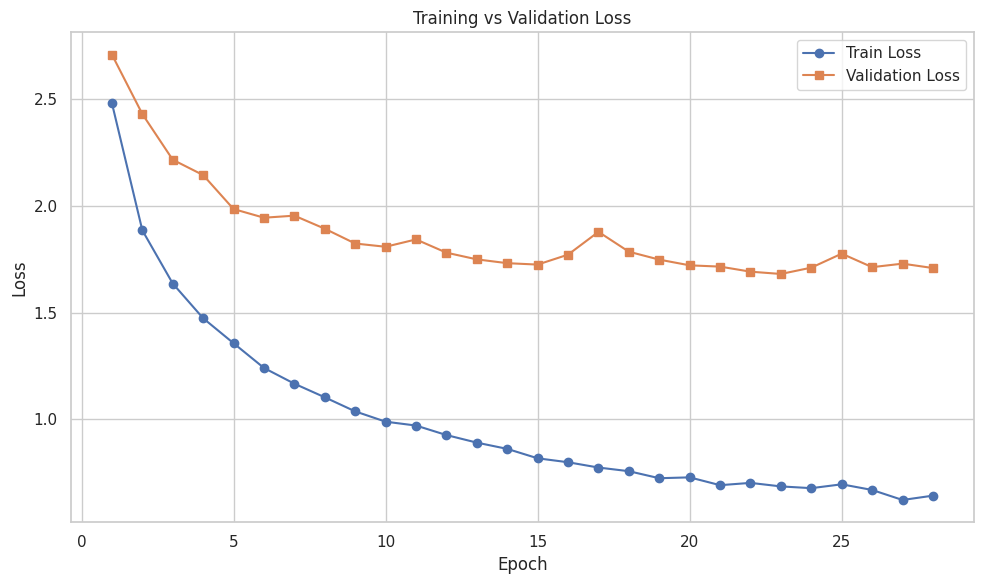

Saved loss graph to: ipykernel_launcher_loss_graph.png


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

sns.set(style="whitegrid")

notebook_name = os.path.splitext(os.path.basename(sys.argv[0]))[0]
save_name = f"{notebook_name}_loss_graph.png"

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='s')

plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()

plt.savefig(save_name)
plt.show()

print(f"Saved loss graph to: {save_name}")

In [8]:
import random
import jiwer
from src.metrics import compute_batch_cer

def build_test_loader(cfg: Config, vocab: Vocabulary):
    split_info = load_split_info(cfg.split_info_path)
    test_ids = split_info.get("split", {}).get("test", [])
    if not test_ids:
        raise ValueError("No test IDs found in split info; regenerate splits first.")

    feature_extractor = LogMelFeatureExtractor(
        sample_rate=cfg.sample_rate,
        n_mels=cfg.n_mels
    )

    test_dataset = JavaneseASRDataset(
        audio_dir=cfg.audio_dir,
        transcript_file=cfg.transcript_file,
        vocab=vocab,
        feature_extractor=feature_extractor,
        apply_spec_augment=False,
        utt_id_filter=test_ids,
    )

    use_pin_memory = torch.cuda.is_available()
    test_loader = DataLoader(
        test_dataset,
        batch_size=cfg.batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=4,
        pin_memory=use_pin_memory,
    )
    return test_dataset, test_loader

test_dataset, test_loader = build_test_loader(current_config, vocab)
decoder_eval = GreedyDecoder(model, vocab, max_len=current_config.max_decode_len, device=current_config.device)

print(f"Test utterances: {len(test_dataset)}; batches: {len(test_loader)}")

model.eval()
all_refs, all_hyps = [], []
total_loss = 0.0
total_cer = 0.0
total_samples = 0
num_batches = 0

with torch.no_grad():
    for batch in test_loader:
        features = batch["features"].to(current_config.device)
        feature_lengths = batch["feature_lengths"].to(current_config.device)
        targets = batch["targets"].to(current_config.device)
        target_lengths = batch["target_lengths"].to(current_config.device)
        transcripts = batch["transcripts"]

        attention_logits, ctc_logits, encoder_lengths = model(features, feature_lengths, targets, teacher_forcing_ratio=0.0)
        loss = model.compute_loss(
            attention_logits=attention_logits,
            targets=targets,
            target_lengths=target_lengths,
            ctc_logits=ctc_logits,
            encoder_lengths=encoder_lengths,
            pad_idx=vocab.pad_idx,
            blank_idx=vocab.blank_idx,
        )

        total_loss += loss.item()
        num_batches += 1

        hyps = decoder_eval.decode(features, feature_lengths)
        cer = compute_batch_cer(transcripts, hyps)
        total_cer += cer * len(transcripts)
        total_samples += len(transcripts)
        all_refs.extend(transcripts)
        all_hyps.extend(hyps)

avg_loss = total_loss / num_batches if num_batches else 0.0
avg_cer = total_cer / total_samples if total_samples else 0.0
avg_wer = jiwer.wer(all_refs, all_hyps) if all_refs else 0.0

print(f"Test avg_loss: {avg_loss:.4f} | avg_cer: {avg_cer:.4f} | avg_wer: {avg_wer:.4f}")

# Randomly sample 5 test utterances for inspection
n_show = min(5, len(test_dataset))
sample_indices = random.sample(range(len(test_dataset)), n_show) if n_show else []
print("Random sample of test predictions:")
for idx in sample_indices:
    feats, tgt, transcript, utt_id = test_dataset[idx]
    feat_len = torch.tensor([feats.size(0)], dtype=torch.long)
    with torch.no_grad():
        hyp = decoder_eval.decode(
            feats.unsqueeze(0).to(current_config.device),
            feat_len.to(current_config.device)
        )[0]
    print(f"[{utt_id}]REF: {transcript} HYP: {hyp}")

Audio file not found for utterance speaker46_f_nn_utt20
Audio file not found for utterance speaker46_f_nn_utt21
Audio file not found for utterance speaker46_f_nn_utt22
Audio file not found for utterance speaker46_f_nn_utt23
Audio file not found for utterance speaker46_f_nn_utt24
Audio file not found for utterance speaker46_f_nn_utt25
Audio file not found for utterance speaker46_f_nn_utt26
Audio file not found for utterance speaker46_f_nn_utt27
Audio file not found for utterance speaker46_f_nn_utt28
Audio file not found for utterance speaker46_f_nn_utt29
Filtered dataset: 2090 -> 410 utterances
Validating audio files...
Loaded 410 valid utterances from data/transcripts.csv
Test utterances: 410; batches: 103
Test avg_loss: 1.9586 | avg_cer: 0.4002 | avg_wer: 0.8016
Random sample of test predictions:
[speaker61_m_nn_utt28]REF: klambine bapak wis suwek kudu didandani HYP: ngambine bapak wis suwe arep udan didandani
[speaker07_m_n_utt23]REF: oleh oleh khas jogja iku bakpia pathok HYP: orah 